In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Метод K ближайших соседей (K nearest neighbors)
<p>Курс "Модели и методы интеллектуального анализа данных"</p>
<p>Чернышов Юрий</p>
<p>к.ф.-м.н., доцент кафедры ИТЗИ УрГУПС (Екатеринбург)</p>
<p>yuchernyshov@usurt.ru</p>

# Оглавление <a name='toc'></a>
<ol>
<li><a href='#intro'>Введение</a></li>
<li><a href='#description'>Описание метода</a></li>
<li><a href='#sklearn'>Реализация метода в библиотеке sklearn</a></li>
<li><a href='#hyper'>Подбор гиперпараметров</a></li>
<li><a href='#example1'>Пример 1: </a></li>
<li><a href='#links'>Ссылки</a></li>
<li><a href='#hometask'>Задание для самостоятельной работы</a></li>    
</ol>

# Описание метода <a name='description'></a>

Метод "К ближайших соседей" (K nearest neighbors, KNN) популярный метод в задачах классификации, но иногда используется в задачах регрессии. Метод заключается в том, что для определения значения неизвестного признака $p$ заданного элемента $E$ определяются ближайшие элементы ("соседи") элемента $E$ и для этой группы соседей определяется среднестатистическое значение признака, которое необходимо определить для исходного элемента $E$ (мы имеем схожие черты с нашим ближайшим окружением). Для работы этого метода необходимо, чтобы было задано "расстояние" между элементами (для определения ближайших соседей как находящихся на кратчайшем расстоянии).

Проиллюстрируем работу метода на простом примере - с помощью векторов чисел, для каждого из которых определен признак цвета: красный (False) или желтый (True). Зададим множество векторов (пар чисел, которые удобно отображать точками на плоскости) и определим для каждого значение признака "желтый" или "красный". $X$, $Y$ - массивы абсцисс и ординат точек, $l$ - массив значений (True, False). Искусственно сгруппируем точки таким образом, чтобы справа вверху и слева внизу преобладали красные точки, а слева вверху и справа внизу - желтые. Используем функцию numpy.r_(), которая объединяет два массива.

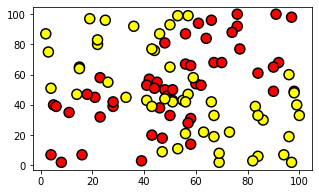

In [2]:
np.random.seed(17)
f = np.random.randint(low=1, high=61, size=(25,2))
X = [i[0] for i in f]; Y = [i[1] for i in f]; l = [False for _ in range(25)]

f = np.random.randint(41, 101, (25,2))
X = np.r_[X,[i[0] for i in f]]; Y = np.r_[Y,[i[1] for i in f]]; l = np.r_[l,[False for _ in range(25)]]

f = [[np.random.randint(1,61), np.random.randint(41,101)] for _ in range(25)]
X = np.r_[X,[i[0] for i in f]]; Y = np.r_[Y,[i[1] for i in f]]; l = np.r_[l,[True for _ in range(25)]]

f = [[np.random.randint(41,101), np.random.randint(1,61)] for _ in range(25)]
X = np.r_[X,[i[0] for i in f]]; Y = np.r_[Y,[i[1] for i in f]]; l = np.r_[l,[True for _ in range(25)]]

plt.rcParams['figure.figsize'] = (5,3)
plt.scatter(X, Y, c=l, s=100, cmap='autumn', edgecolors='black', linewidth=1.5);

Возьмем произвольную точку $A$ с координатами (10,10) и определим для нее группы из 3, 5, 11, 71 ближайших соседей. Расстояние между двумя точками $(x_0, y_0)$ и $(x_1, y_1)$ определяется по формуле
$$
\rho = \sqrt{(x_1 - x_0)^2+(y_1 - y_0)^2},
$$
и эти расстояния от всех точек до точки $A(10,10)$ будут храниться в списке $dist$. Отсортируем список $dist$ и сохраним в список $indexes$ индексы ближайших к $A$ соседей.

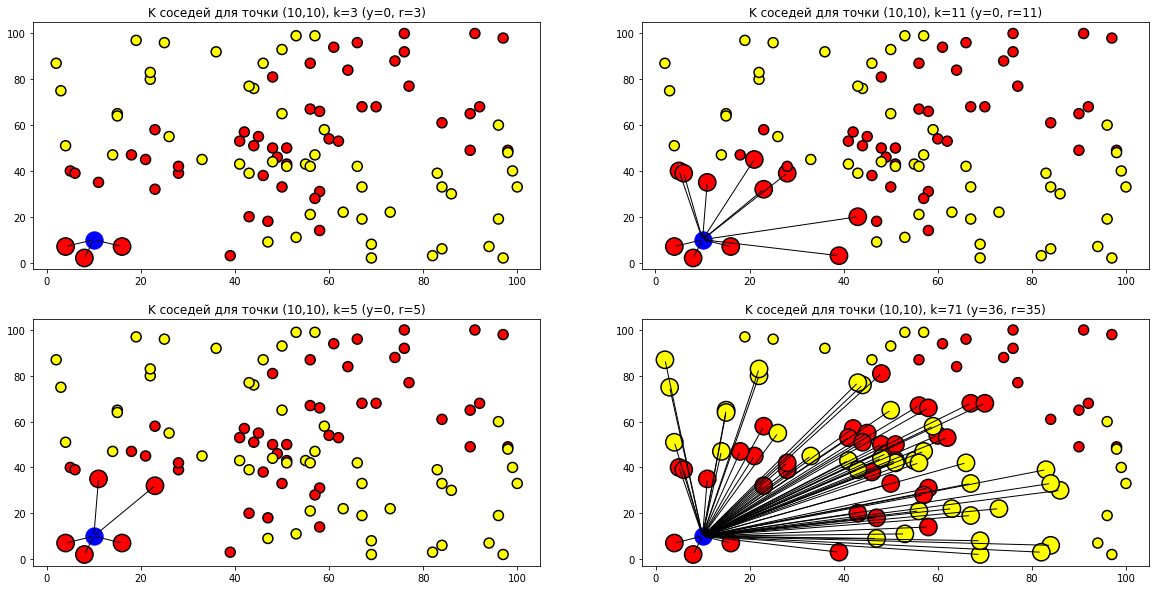

In [3]:
A = (10, 10)
dist = [(i, np.sqrt((X[i]-A[0])**2+(Y[i]-A[1])**2)) for i in range(len(X))]

plt.rcParams['figure.figsize']=(20,10)
fig, ax = plt.subplots(2, 2)
for pos, n in enumerate([3, 5, 11, 71]):
    indexes = [i for (i, _) in sorted(dist, key=lambda x: x[1])[:n]]
    sizes = [300 if i in indexes else 100 for i in range(100)]
    ax[pos%2][pos//2].scatter(X, Y, c=l, s=sizes, cmap='autumn', edgecolors='black', linewidth=1.5);
    ax[pos%2][pos//2].scatter(A[0], A[1], c='b', s=300)
    y, r = 0, 0
    for i in indexes:
        if l[i]: r+=1 
        else: y+=1
        ax[pos%2][pos//2].annotate (u'', 
                                    xy=(A[0], A[1]), 
                                    xytext = (X[i], Y[i]),
                                    arrowprops = {'arrowstyle': '-'})
    ax[pos%2][pos//2].set_title("K соседей для точки ({},{}), k={} (y={}, r={})".format(A[0], A[1], n, r, y))
plt.show()

На диаграммах видим новую точку $A$ и ближайшие к ней $K$ соседей, а также статистику цвета "желтый-красный" для данной группы соседей. Далее признак для новой точки выбирается как наиболее часто встречающийся среди $K$ соседей. В том случае если количество желтых и красных примерно (или строго) равно - можно уменьшить количество соседей. Этот процесс можно продолжать, в итоге в самом плохом случае останется один сосед ($K$=1) с помощью которого можно определить искомое значение признака.

Из приведенного примера ясно, что количество соседей $K$ имеет сильное влияние на качество работы метода. Для слишком малого или, наоборот, слишком большого числа соседей не удастся получить качественную статистику для группы. Например, для малых значений $n$=3 и $n$=5 цвет определяется одназначно, но для $n$=71 оценка даже меняется на противоположную, так как в группе из 71 соседа начинают преобладать "желтые".

Для повышения точности вклад соседей в получение оценки для элемента может учитывать удаленность соседа от элемента - для более удаленных соседей вклад меньше (т.е. к оценке добавляется вес, с учетом расстояния).

<a href='#toc'>Назад к Оглавлению</a>

# Реализация метода KNN в библиотеке sklearn <a name='sklearn'></a>

Для реализации метода KNN в библиотеке sklearn есть классификатор sklearn.neighbors.KNeighborsClassifier.

In [4]:
# sklearn.neighbors.KNeighborsClassifier()
clf = KNeighborsClassifier(n_neighbors=10)

**Параметры классификатора KNeighborsClassifier**

* algorithm='auto': 'auto', 'ball_tree', 'kd_tree', 'brute' - различные алгоритмы вычисления расстояний между ближайшими соседями,

* leaf_size=30, количество листьев для алгоритмов BallTree и KDTree (если выбраны в предыдущем параметре),

* metric='minkowski', используемая метрика для определения расстояния, м.б. также 'euclidean', расстояние Хэмминга, косинусное расстояние

* metric_params=None, параметры метрики

* n_jobs=None, количество используемых для расчета процессоров (n_jobs=-1 означает - задействовать все процессоры)

* n_neighbors=5, количество соседей

* p=2, параметр для метрики Минковского (если выбрана)

* weights='uniform', 'distance' или вызываемая функция - определение весов для удаленности соседей

#### Метрики

Манхэтенская метрика
$$
\rho(x,y) = \sum_{i=1}^{n}{|x_i-y_i|}
$$

Евклидова метрика
$$
\rho (x,y) = \sqrt{\sum_{i=1}^{n}{(x_i-y_i)^2}}
$$

Метрика Минковского (обобщение евклидовой и манхэттенской метрик)
$$
\rho(x,y) = \left( \sum_{i=1}^{n}{|x_i - y_i|^p} \right)^\frac{1}{p}
$$

Косинусное расстояние
$$
\rho(x,y)=\cos(\alpha) = \frac{x \cdot y }{|x||y|} = 
\frac{\sum_{i=1}^{n}{x_i y_i}}{\sum_{i=1}^{n}{x_i^2} \sum_{i=1}^{n}{y_i^2}}
$$

Обучим классификатор со значениями параметров по умолчанию (например, количество соседей n_neighbors=5) на наших данных.

In [5]:
clf.fit(np.c_[X,Y], l)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

С помощью классификатора находим, что для выборок с количеством соседей n=5 новая точка с координатами (10,10) будет красной (False), что согласуется с графиком выше.

In [6]:
clf.predict(np.array([10,10]).reshape(-1,2))

array([False])

Для n=5 новая точка с координатами (80,20) будет желтой (True). Однако для количества соседей n=71 результат для точки (80,20) будет обратный, так как среди 71 ее ближайших соседей преобладают "красные".

In [7]:
clf.predict(np.array([80,20]).reshape(-1,2))

array([ True])

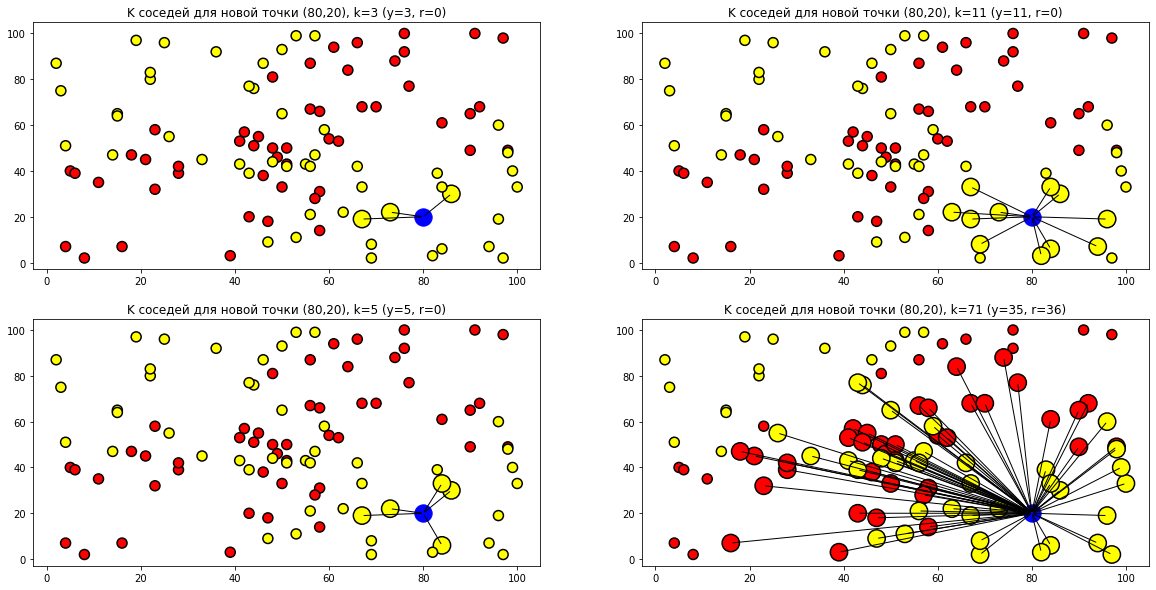

In [8]:
new_point = (80, 20)
dist = [(i, np.sqrt((X[i]-new_point[0])**2+(Y[i]-new_point[1])**2)) for i in range(len(X))]

plt.rcParams['figure.figsize']=(20,10)
fig, ax = plt.subplots(2, 2)
for pos, n in enumerate([3, 5, 11, 71]):
    indexes = [i for (i, _) in sorted(dist, key=lambda x: x[1])[:n]]
    sizes = [300 if i in indexes else 100 for i in range(100)]
    ax[pos%2][pos//2].scatter(X, Y, c=l, s=sizes, cmap='autumn', edgecolors='black', linewidth=1.5);
    ax[pos%2][pos//2].scatter(new_point[0], new_point[1], c='b', s=300)
    y, r = 0, 0
    for i in indexes:
        if l[i]:
            r+=1
        else:
            y+=1
        ax[pos%2][pos//2].annotate (u'', 
                                    xy=(new_point[0], new_point[1]), 
                                    xytext = (X[i], Y[i]),
                                    arrowprops = {'arrowstyle': '-'})
    ax[pos%2][pos//2].set_title("K соседей для новой точки ({},{}), k={} (y={}, r={})".format(new_point[0], 
                                                                                              new_point[1], 
                                                                                              n, r, y))
plt.show()

In [9]:
KNeighborsClassifier(n_neighbors=71).fit(np.c_[X,Y],l).predict(np.array([80,20]).reshape(-1,2))

array([False])

<a href='#toc'>Назад к Оглавлению</a>

# Подбор гиперпараметров <a name='hyper'></a>

Для классификатора KNeighborsClassifier можно подбирать параметры (например, количество соседей n_neighbors) с помощью кросс-валидации. Чтобы оценить качество подбора параметра разделим имеющийся набор точек на выборки тренировочную (train) и проверочную (valid), параметр будем подбирать на выборке train, после чего оценим качество его подбора на выборке valid.

In [10]:
data_train, data_valid, labels_train, labels_valid = train_test_split(np.c_[X,Y], np.array(l), test_size=0.1)

In [11]:
data_train.shape, labels_train.shape, data_valid.shape, labels_valid.shape

((90, 2), (90,), (10, 2), (10,))

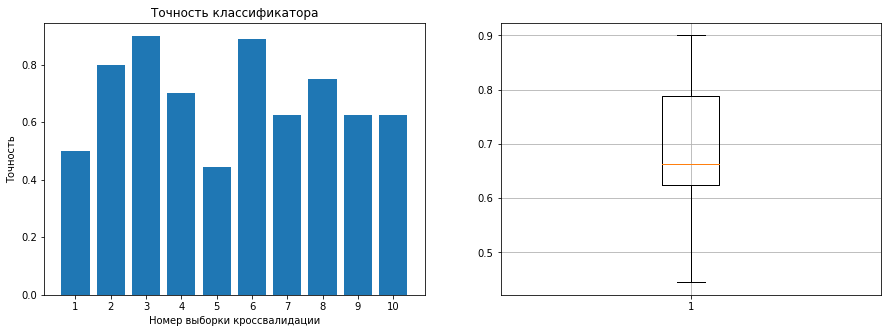

In [12]:
result = cross_validate(clf, data_train, labels_train, cv=10)
plt.rcParams['figure.figsize'] = (15,5)
fig, ax = plt.subplots(1,2)
ax[0].set_xticks(range(1,11))
ax[0].bar(range(1,11), result['test_score'])
ax[0].set_xlabel("Номер выборки кроссвалидации")
ax[0].set_ylabel("Точность")
ax[0].set_title("Точность классификатора")
ax[1].boxplot(result['test_score'])
ax[1].grid(True)
plt.show()

In [13]:
print("Минимальное значение точности: {:.2f}, среднее значение: {:.2f}".format(result['test_score'].min(),
                                                                         result['test_score'].mean()))

Минимальное значение точности: 0.44, среднее значение: 0.69


Постараемся улучшить точность с помощью подбора гиперпараметров. Для этого используется метод GridSearchCV которому на вход задается перечень значений параметров из которых он выбирает оптимальный.

In [14]:
clf_grid = GridSearchCV(clf, param_grid={'n_neighbors': range(1,50)}, cv=10)

In [15]:
clf_grid.fit(data_train, labels_train)

C:\Users\Chernishov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=10, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': range(1, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
print(clf_grid.best_estimator_, clf_grid.best_params_, clf_grid.best_score_)
print(accuracy_score(labels_valid, clf_grid.best_estimator_.predict(data_valid)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform') {'n_neighbors': 1} 0.7333333333333333
1.0


Используем теперь веса для соседей с различной удаленностью.

In [17]:
clf_grid1 = GridSearchCV(clf, param_grid={'n_neighbors': range(1,30), 'weights':['uniform','distance']}, cv=15)

In [18]:
clf_grid1.fit(data_train, labels_train)

C:\Users\Chernishov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=15, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=10, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
clf_grid1.best_estimator_, clf_grid1.best_params_, clf_grid1.best_score_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='distance'),
 {'n_neighbors': 5, 'weights': 'distance'},
 0.7555555555555555)

In [20]:
accuracy_score(labels_valid, clf_grid1.best_estimator_.predict(data_valid))

1.0

Видим, что для нашего примера учет удаленности точек делает предсказание более точным, что согласуется с диаграммой - точки одного класса расположены близко друг к другу.

<a href='#toc'>Назад к Оглавлению</a>

# Пример 1 <a name='example1'></a>

<a href='#toc'>Назад к Оглавлению</a>

# Ссылки <a name='links'></a>

<a href='#toc'>Назад к Оглавлению</a>

# Задания для самостоятельной работы <a name='hometask'></a>

<a href='#toc'>Назад к Оглавлению</a>